<a href="https://colab.research.google.com/github/Gedeon-m-gedus/Image_Processing/blob/master/CV_14_NN_compression_LAB3_answers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
!pip install tensorly
import tensorly as tl
#Need to set Tensorly's backend as pytorch
tl.set_backend('pytorch')
from tensorly import random, tenalg
import numpy as np
np.random.seed(0)
import copy 
import time
def tic():
  return time.time()
def toc(t):
  return time.time()-t


     |████████████████████████████████| 71kB 1.9MB/s 
     |████████████████████████████████| 163kB 7.5MB/s 
  Created wheel for tensorly: filename=tensorly-0.4.5-cp36-none-any.whl size=100156 sha256=9d0ea97e2e0f37b1a41f3c7602f061ad5cf2a846d762d68f285393fd5e616c5a
  Stored in directory: /root/.cache/pip/wheels/44/ae/02/8d00229a4fd0af192b48d24da903f9975c7ac10e706685fc39
Successfully built tensorly


#Background
In recent researches, we have seen numerous successes with neural networks, epseicially deep learning methods. However, for these deep architectures, the number of parameters is often extremely big. This overparameterized structure, although often has state-of-the-art performance, also suffers from  long processing time and the need of expensive hardwares. Therefore, many efforts have been made into deriving deep learning models with less number of parameters but still remains similar performance. One interesting idea is to leverage the structure of matrix product operator (MPO) and represent the weights of the NN using this MPO format and directly do gradient descent w.r.t this structure. In this practice, we will explore how to train a fully connected neural network in its matrix product operator format. \\
This practice is inspired by the paper: https://arxiv.org/abs/1509.06569

# Directly learning the MPO represented NN (MPO-NN)
## Detour: What is MPO and how to contract a MPO with an input tensor?



Matrix product operator (MPO) is essentially an MPS with one extra leg on each core. For example, in the following figure, we should a typical MPO structure of the tensor $\mathcal{G} = [\mathcal{G}_1, \mathcal{G}_2, \mathcal{G}_3, \mathcal{G}_4]$, which is of size $c_1\times c_2\times c_3\times c_4\times d_1\times d_2\times d_3\times d_4$. As a similar notion to MPS, the leg connecting each core representing the MPO rank. In this example, the rank of the MPO is a list of $[r_1, r_2, r_3]. $![MPO_strcurtre](https://docs.google.com/uc?export=download&id=1a9GRYOhrC8Zn_rcumigt8gc4EZkKJJuz)

### 1. 
In this first problem, you will need to implement the MPO contraction operation between a MPO and an input tensor $\mathcal{X}$. Assuming you are given a MPO $\mathcal{G}$ which is a list of MPO cores, i.e. $[\mathcal{G}_1, \cdots \mathcal{G}_m]$ and the MPO is of the rank $[r_1 \cdots r_{m-1}]$. We also assume that the i-th core is of the shape $r_{i-1}\times d_i\times c_i\times r_i$, where for the first core we let $r_{0}= 1$ and for the last core $r_m = 1$ (Note a leg with dimension 1 is equivalent to an empty leg), as shown in the following figure. 

![MPO_core](https://docs.google.com/uc?export=download&id=1OAWiLk3kCBarhzQ6-BhmFyabmZi65eSh) 




Now, given an input tensor $\mathcal{X}\in \mathbb{R}^{n \times d_1 \times \cdots \times d_m}$, where n is the batch size, implement the contraction between the corresponding legs such that the contracted tensor will be of size $n \times c_1\times \cdots \times c_m$. As an example, for an MPO with 4 cores, the contraction between it and an input tensor $\mathcal{X}$ is shown as the following:

![MPO_strcurtre](https://docs.google.com/uc?export=download&id=1pOQn5YeqfwWWD7mIemC3sYjecp59IYue) 

In [ ]:
def MPO_contraction(mpo, x, return_vec = True):
  '''
  mpo: a list of MPO cores (tensorly format), the i-th core is of shape (r_{i-1}, d_i, c_i, r_i), 
       for the first core r_0 =1, for the last core r_m = 1.
  x: input tensor to be contracted (tensorly format), should be of size (n, d_1, d_2, ..., d_m).
  return: a tensor of shape (n, c_1, c_2, ..., c_m)
  '''
  assert len(mpo) == x.ndim - 1, "dimension mismatch between MPO and input tensor x"
  for i in range(len(mpo)):
    assert mpo[i].shape[1] == x.shape[i+1], str(i)+"th core does not match the input dimension, note the thrid dimension of the mpo core should be the same of the corresponding input tensor dimension" 

  output_tmp = tenalg.contract(x, [1], mpo[0], [1])
  for i in range(1, x.ndim - 1):
    output_tmp = tenalg.contract(output_tmp, [1, output_tmp.ndim - 1], mpo[i], [1, 0])
  return output_tmp.squeeze()

In [ ]:
results = [[410.3555, 367.0687, 394.2908, 358.6689, 381.4024, 341.9384, 360.2169,
        329.8646, 407.1425, 363.4720, 393.6679, 355.0994, 390.3836, 349.0190,
        371.2960, 335.3856, 381.8200, 349.6505, 372.9323, 343.3012, 366.3085,
        336.4729, 351.3506, 325.3335], 
       [356.8043, 418.2853, 361.2211, 410.5959, 316.2948, 370.2491, 312.2206,
        352.7069, 382.1384, 444.2850, 380.6153, 436.5235, 355.7083, 413.0649,
        344.6199, 393.3047, 396.4348, 455.7986, 393.3049, 447.2321, 361.2296,
        414.9194, 348.0826, 394.7057],
        [354.9081, 293.2105, 359.8825, 296.4861, 377.5464, 315.0949, 377.2471,
        312.9066, 370.3658, 318.1749, 367.7635, 312.0098, 404.4339, 350.1533,
        393.8055, 334.7884, 376.3939, 327.9788, 379.5774, 330.4409, 408.0018,
        352.9874, 404.4712, 350.2234],
        [318.2197, 296.4062, 346.0204, 326.2782, 296.7090, 278.4173, 326.6268,
        307.8708, 329.1500, 309.8562, 356.8482, 340.7281, 308.3035, 291.0971,
        335.1161, 318.2343, 336.9507, 307.0458, 366.0646, 340.7538, 315.1257,
        290.0126, 346.2084, 322.9559],
        [318.1615, 349.5595, 331.5495, 369.5155, 328.6678, 364.3328, 342.3642,
        382.9929, 330.7670, 360.3952, 347.7114, 379.8224, 354.8564, 389.9683,
        370.4451, 407.6407, 355.8427, 385.7378, 372.6829, 404.4416, 379.2988,
        412.8916, 393.8806, 429.8946],
        [270.0208, 350.8890, 262.4508, 333.1976, 293.0804, 382.3908, 288.4987,
        368.0071, 282.7515, 381.6471, 271.3544, 362.4180, 303.4720, 409.4315,
        296.4285, 395.9372, 333.2086, 421.1110, 319.1843, 399.1218, 358.9009,
        454.4263, 350.2224, 437.3429],
        [352.3250, 368.0678, 358.6050, 376.5540, 373.9196, 390.7939, 386.3511,
        400.3182, 359.8570, 371.7061, 368.3690, 378.2644, 375.4347, 388.3662,
        389.0728, 397.3719, 391.6757, 409.0408, 401.8670, 415.1198, 410.2174,
        428.3144, 426.0149, 437.9070],
        [389.6984, 366.2637, 408.0897, 381.6472, 333.4066, 313.0393, 353.7299,
        331.9791, 415.8656, 384.7394, 432.8951, 405.1320, 356.6425, 330.8488,
        379.1675, 357.9731, 456.8054, 414.1855, 482.8067, 437.2590, 393.1959,
        357.1537, 421.8253, 384.6655],
        [343.7931, 335.9971, 359.5031, 351.5452, 298.8585, 291.3354, 321.7639,
        311.5385, 319.9868, 315.0025, 331.4951, 329.4894, 281.8465, 278.9174,
        299.7816, 297.7877, 338.9509, 337.0882, 350.7429, 348.8928, 305.9270,
        303.5083, 326.6728, 323.9245],
        [542.8569, 527.5298, 541.1932, 531.6619, 430.4786, 419.5898, 421.7222,
        409.8663, 523.4540, 494.5858, 518.2686, 499.6876, 395.8323, 376.9006,
        383.6669, 367.5051, 512.1805, 493.6794, 503.1376, 493.2400, 402.5128,
        393.7093, 390.9211, 382.5303] ]

You can run the following program to make sure the output of your function is correct. 

In [ ]:
#Test for MPO_contraction
np.random.seed(0)
for k in range(10):
  x = tl.tensor(np.random.rand(3, 4, 5, 6))
  mpo = []
  rank = 7
  out_dim = 2
  for i in range(1, x.ndim):
    if i == 1:
      dim_0 = 1 
    else:
      dim_0 = rank
    if i == x.ndim - 1:
      dim_3 = 1
    else:
      dim_3 = rank
    dim_1 = x.shape[i]
    dim_2 = out_dim
    tmp = tl.tensor(np.random.rand(dim_0, dim_1, dim_2, dim_3))
    mpo.append(tmp)
  out = tl.to_numpy(tl.tensor_to_vec(MPO_contraction(mpo, x))).round(decimals = 4)
  results[k] = np.asarray(results[k])
  if ((out - results[k]) < 1e-3).all():
    print('Test '+str(k)+' passed!')
  else:
    print('Test '+str(k)+' failed!')

Test 0 passed!
Test 1 passed!
Test 2 passed!
Test 3 passed!
Test 4 passed!
Test 5 passed!
Test 6 passed!
Test 7 passed!
Test 8 passed!
Test 9 passed!


## Define the MPO-NN stucture the forward pass
### 2. 
From the structure of MPO we can see that an MPO essentially has two set of legs: using the previous notations, one set is $\{c_1,\cdots c_m\}$, the other one is $\{d_1,\cdots d_n\}$. In the above problem, we implemented the contraction between the input tensor and one set of legs of the MPO. The resulted tensor is of shape $(n, c_1, \cdots, c_m)$. Note this can be seen as another input tensor and can be contracted with another MPO. One can see that this layer-by-layer structure is very similar to multi-layer perceptron (MLP). The idea of MPO neural networks, or the so-called tensorized neural networks, is to replace the fully-connected (or convolutional layer) weights (i.e. weight matrices) by an MPO structure, then use gradient descent to learn these MPO layers. This replacement will drastically reduce the number of parameters that the neural networks need. In this problem, we will be implementing MPO-NN to replace a fully connected neural networks. The dataset we use here is the classic MNist hand-written dataset, which contains pictures of size $28\times 28$. 



# Prepare the data

In this practice, we will be using the classic Mnist dataset. The first step is of course to load the dataset from Pytorch. 

In [ ]:
use_cuda = True # we will be using gpu to train the model, therefore setting use_cuda to True
batch_size = 512
test_batch_size = 2048
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
# Load MNIST dataset from pytorch using dataloader
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Then let us create training_loader, validation_loader and test_loader for our data to facilitate our training process later on. 

In [ ]:
# Use the first 50000 data for training and the rest for validation
train_ds  = torch.utils.data.Subset(train_loader.dataset, range(0, 50000-1))
train_ds = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True, **kwargs)
valid_ds = torch.utils.data.Subset(train_loader.dataset, range(50000, 60000-1))
valid_ds = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True, **kwargs)

#### (a)
In this problem, you need to implement the function `MPO_layer`, which takes a list of mpo ranks, a list of input tensor dimensions and a list of output tensor dimensions. The function outputs a list of MPO cores with corresponding dimensions determined by the input argument. For example, if `mpo_rank = [2,3]`, `input_dims = [4,5,6]`, `output_dims = [7,8,9]`, then the output of this function should be a list of 3 tensors, which are of shape `(1,4,7,2)`, `(2,5,8,3)` and `(3,6,9,1)`. Each core should be initialized with weights drawn from a uniform distribution $(-1/sqrt(a), 1/sqrt(a))$, where $a$ is the number of parameters for the corresponding core.

In [ ]:
def get_tensor_size(tensor):
  size_tmp = 1.
  for dim in tensor.size():
    size_tmp *= dim
  return size_tmp
  
def get_tensor_size_given_shape(shape):
  size_tmp = 1.
  for dim in shape:
    size_tmp *= dim
  return size_tmp
def check_list_and_int(x, var_name):
  assert isinstance(x, list) or isinstance(x, int), 'Expecting ' + var_name + ' to be int or a list of int'
  if isinstance(x, list):
    assert all(isinstance(item, int) for item in x), 'Expecting ' + var_name + ' to be int or a list of int'
  return 


def MPO_layer(mpo_rank, input_dims, output_dims, num_cores = None, seed = 0, device = 'cuda'):
  check_list_and_int(mpo_rank, 'mpo_rank')
  check_list_and_int(input_dims, 'input_dims')
  check_list_and_int(output_dims, 'output_dims')
  if isinstance(input_dims, list) and isinstance(output_dims, list):
    assert len(input_dims) == len(output_dims), 'if both input_dims and output_dims are list, then len(input_dims) should be the same as len(output_dims)'
  if isinstance(input_dims, list) or isinstance(output_dims, list):
    if num_cores is None:
      num_cores = len(input_dims) if isinstance(input_dims, list) else len(output_dims)
    else:
      num_cores_dims = len(input_dims) if isinstance(input_dims, list) else len(output_dims)
      assert num_cores_dims == num_cores, 'The length of the input_dims/output_dims mismatch num_cores'
  else:
    assert num_cores is not None, 'If input_dims and output_dims are not list, you need to specify num_cores'
  if isinstance(mpo_rank, list):
    assert len(mpo_rank) + 1 == num_cores, 'len(mpo_rank) + 1  should be the same as num_cores/len(input_dims)/len(output_dims)'
      
  np.random.seed(seed)
  mpo_layer = []
  for i in range(num_cores):
    if i == 0:
      dim_0 = 1
    else:
      dim_0 = mpo_rank[i-1] if isinstance(mpo_rank, list) else mpo_rank
    if i == num_cores - 1:
      dim_3 = 1
    else:
      dim_3 = mpo_rank[i] if isinstance(mpo_rank, list) else mpo_rank
    dim_1 = input_dims[i] if isinstance(input_dims, list) else input_dim
    dim_2 = output_dims[i] if isinstance(output_dims, list) else output_dim

    tmp = tl.tensor(np.random.rand(dim_0, dim_1, dim_2, dim_3))
    bound = 1./np.sqrt(get_tensor_size(tmp))
    
    tmp = tmp*2*bound - bound
    mpo_layer.append(tl.tensor(tmp, device = device, requires_grad=True))
  return mpo_layer

#### (b)
Finish writing the class `Net_MPO`, you will need to implement the `__init__` function and the `forward` function. In `__init__` you will need to define the network structure using the function `MPO_layer` you have just implemented in the previous question. 

For `__init__`, you will need to write the strcutre of the MPO-NN. For this particular problem, the network you will be implementing has two MPO layers and then a fully  connected layer to connect to the output. After each MPO layers, there are two `ReLu` layer, which takes the intermediate output and pass it through a `ReLu` function. You will need to construct a list of MPO layers, which is called `self.mpo_layers`, this should contain 2 lists, each of the list correspond to the MPO cores for that particular MPO layer. The function takes 5 arguements, `number_layers` indicates how many layers you want for the MPO-NN; `mpo_rank` is a list of MPO ranks for each MPO layer. For example, if there are 2 MPO layers, then `mpo_rank` is a list of two lists, where each list contains the MPO ranks for the respective MPO layer. `hidden_dims`  is also in this format, it is a list of all hidden layer dimensions. These hidden layer dimensions correspond to the output tensor shape of each MPO layer that you have implemented in the `MPO_layer` function. `input_shape` is the input tensor's shape and finally `output_dim` is the output dimension. For this particular dataset, the `output_dim` is 10 (10 classes in total). **Use the default parameters for your network structure.**
 

For `forward` function, it only takes the input tensor of size $(n, 28, 28)$ as argument, where $n$ is the batch size and $28\times 28$ is the input image's dimension. The output shape of this function should be $n \times 10$. You will first need to reshpe the input tensor to the input_shape defined in the `__init__` function. Then you will need to write a forward pass of the desginated MPO networks, which contains two contractions with the MPO layers and use `ReLu` function to activate after each MPO contraction and finally multiply by the last fully connected layer. **Use the function you implemented in (1)**

In [ ]:
class Net_MPO(nn.Module):
  def __init__(self, number_layers = 2, mpo_ranks = [[5, 5, 5], [5,5,5]], 
               input_shape = [4, 7, 4, 7], output_dim = 10, 
               hidden_dims = [[5, 5, 5, 5], [5, 5, 5, 5]], seed = 0, device = 'cuda'):
    super(Net_MPO, self).__init__()
    assert number_layers == len(mpo_ranks), 'Len(mpo_ranks) should be the same as number of layers'
    assert len(hidden_dims) == number_layers, 'Len(hidden_dims) should be number of layers minus 1'

    # Construct MPO layers
    mpo_layers = []
    mpo_layer = MPO_layer(mpo_rank = mpo_ranks[0], input_dims = input_shape, output_dims = hidden_dims[0], num_cores = None, seed = 0, device = 'cuda')
    mpo_layers.append(mpo_layer)
    for i in range(1, number_layers):
      mpo_layer = MPO_layer(mpo_rank = mpo_ranks[i], input_dims = hidden_dims[i-1], output_dims = hidden_dims[i], num_cores = None, seed = 0, device = 'cuda')
      mpo_layers.append(mpo_layer)
    self.mpo_layers = mpo_layers

    #Construct final fully-connected layer
    fc_in = get_tensor_size_given_shape(hidden_dims[-1])
    self.fc = nn.Linear(int(fc_in), output_dim).to(device)

    #Some class properties that might come handy
    self.output_dim = output_dim
    self.input_shape = input_shape
    self.device = device

  def forward(self, x):
    new_shape = [-1]
    for i in self.input_shape:
      new_shape.append(i)
    inter_out = tl.tensor(x.reshape(new_shape)).to(self.device)

    for mpo_layer in self.mpo_layers:
      inter_out = MPO_contraction(mpo_layer, inter_out)
      inter_out = F.relu(inter_out)
    inter_out = tl.unfold(inter_out, 0).to(self.device)
    
    out = self.fc(inter_out)
    out = F.log_softmax(out, dim=1)
    return out

  def get_number_parameters(self):
    size = 0
    for mpo_layer in self.mpo_layers:
      for core in mpo_layer:
        size += get_tensor_size_given_shape(core.shape)
    fc_layer_shape = hidden_dims[-1]
    fc_layer_shape.append(self.output_dim)
    size += get_tensor_size_given_shape(fc_layer_shape)
    return size


## Training MPO-NN

The training and testing methods for the MPO-NN

In [ ]:
#The train and test function of the Tensorized Network
def train(model, device, train_loader, optimizer, epoch, log_interval = 10):
    model.train()
    error = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data).to(device)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
          
        error.append(loss.item())
    return sum(error)/len(error)


def test(model, device, test_loader, return_acc = False):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data).to(device)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    if return_acc:
      return 100. * correct / len(test_loader.dataset)
    else:
      return test_loss


Hyper-parameters setup

In [ ]:
lr = 0.01
save_model = True
epochs = 10
torch.manual_seed(1)
gamma = 0.5
log_interval = 100
step_size = 3
device = torch.device("cuda" if use_cuda else "cpu")
number_layers = 2
mpo_ranks = [[5, 5, 5], [5,5,5]] 
input_shape = [4, 7, 4, 7]
output_dim = 10
hidden_dims = [[5, 5, 5, 5], [5, 5, 5, 5]]
seed = 0

Training process

In [ ]:

model_MPO = Net_MPO(number_layers = number_layers, mpo_ranks =mpo_ranks, 
               input_shape = input_shape, output_dim = output_dim, 
               hidden_dims = hidden_dims, seed = seed)
params = model_MPO.mpo_layers[0] + model_MPO.mpo_layers[0]
#print(model_MPO.get_number_parameters())
params.append(model_MPO.fc.weight)

optimizer = optim.Adam(params , lr=lr)
# scheduler for automatic decaying the learning rate
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
                   
train_loss_tt = []
test_loss_tt = []

# Training
for epoch in range(1, epochs + 1):
    train_loss_tt.append(train(model_MPO, device, train_ds, optimizer, epoch, log_interval))
    test_loss_tt.append(test(model_MPO, device, valid_ds))
    scheduler.step()

# Testing
t = tic()
MPO_acc = test(model_MPO, device, test_loader, return_acc = True)
time_MPO = toc(t)
if save_model:
    torch.save(model_MPO.state_dict(), "mnist_mpo.pt")

/usr/local/lib/python3.6/dist-packages/tensorly/backend/pytorch_backend.py:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  requires_grad=requires_grad)


Train Epoch: 1 [0/49999 (0%)]	Loss: 2.301429

Test set: Average loss: 0.2443, Accuracy: 9313/9999 (93%)

Train Epoch: 2 [0/49999 (0%)]	Loss: 0.349698

Test set: Average loss: 0.1686, Accuracy: 9518/9999 (95%)

Train Epoch: 3 [0/49999 (0%)]	Loss: 0.215096

Test set: Average loss: 0.1413, Accuracy: 9594/9999 (96%)

Train Epoch: 4 [0/49999 (0%)]	Loss: 0.107486

Test set: Average loss: 0.1212, Accuracy: 9667/9999 (97%)

Train Epoch: 5 [0/49999 (0%)]	Loss: 0.072934

Test set: Average loss: 0.1159, Accuracy: 9675/9999 (97%)

Train Epoch: 6 [0/49999 (0%)]	Loss: 0.082413

Test set: Average loss: 0.1135, Accuracy: 9671/9999 (97%)

Train Epoch: 7 [0/49999 (0%)]	Loss: 0.086253

Test set: Average loss: 0.1074, Accuracy: 9692/9999 (97%)

Train Epoch: 8 [0/49999 (0%)]	Loss: 0.076102

Test set: Average loss: 0.1056, Accuracy: 9693/9999 (97%)

Train Epoch: 9 [0/49999 (0%)]	Loss: 0.100694

Test set: Average loss: 0.1031, Accuracy: 9704/9999 (97%)

Train Epoch: 10 [0/49999 (0%)]	Loss: 0.076554

Test set

## Learning fully connected NN
### FCNN structure


In [ ]:

class Net(nn.Module):
    def __init__(self, hidden_units = 300, fc_weights = None):
        super(Net, self).__init__()
        self.hidden_units = hidden_units
        if fc_weights is None:
          self.fc1 = nn.Linear(28*28, hidden_units)
          self.fc2 = nn.Linear(hidden_units, hidden_units)
          self.fc3 = nn.Linear(hidden_units, 10)
        else:
          self.fc1 = nn.Linear(28*28, hidden_units)
          self.fc2 = nn.Linear(hidden_units, hidden_units)
          self.fc3 = nn.Linear(hidden_units, 10)
          self.fc1.weight.data = torch.tensor(fc_weights[0])
          self.fc2.weight.data = torch.tensor(fc_weights[1])
          self.fc3.weight.data = torch.tensor(fc_weights[2])

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.leaky_relu(x)
        x = self.fc2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        output = F.log_softmax(x, dim=1)
        #print(output[0])
        return output
        
    def get_number_parameters(self):
      return 28*28 * self.hidden_units + self.hidden_units**2 + self.hidden_units * 10

### Hyper-parameters setup

In [ ]:
use_cuda = True
batch_size = 512
test_batch_size = 2048
lr = 0.001
save_model = True
epochs = 10
torch.manual_seed(1)
gamma = 0.1
log_interval = 100
hidden_units = 625
step_size = 5



### Training process

In [ ]:
model_fc = Net(hidden_units).to(device)
optimizer = optim.Adam(model_fc.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

train_loss_fc = []
test_loss_fc = []

for epoch in range(1, epochs + 1):
    train_loss_fc.append(train(model_fc, device, train_ds, optimizer, epoch, log_interval))
    test_loss_fc.append(test(model_fc, device, valid_ds))
    scheduler.step()

t = tic()
fc_acc = test(model_fc, device, test_loader, return_acc = True)
time_fc = toc(t)
if save_model:
    torch.save(model_fc.state_dict(), "mnist_fc.pt")


Train Epoch: 1 [0/49999 (0%)]	Loss: 2.303605

Test set: Average loss: 0.1589, Accuracy: 9535/9999 (95%)

Train Epoch: 2 [0/49999 (0%)]	Loss: 0.159265

Test set: Average loss: 0.1054, Accuracy: 9684/9999 (97%)

Train Epoch: 3 [0/49999 (0%)]	Loss: 0.107164

Test set: Average loss: 0.0950, Accuracy: 9721/9999 (97%)

Train Epoch: 4 [0/49999 (0%)]	Loss: 0.051664

Test set: Average loss: 0.0934, Accuracy: 9715/9999 (97%)

Train Epoch: 5 [0/49999 (0%)]	Loss: 0.040534

Test set: Average loss: 0.0789, Accuracy: 9758/9999 (98%)

Train Epoch: 6 [0/49999 (0%)]	Loss: 0.029279

Test set: Average loss: 0.0611, Accuracy: 9829/9999 (98%)

Train Epoch: 7 [0/49999 (0%)]	Loss: 0.009920

Test set: Average loss: 0.0605, Accuracy: 9830/9999 (98%)

Train Epoch: 8 [0/49999 (0%)]	Loss: 0.007672

Test set: Average loss: 0.0608, Accuracy: 9828/9999 (98%)

Train Epoch: 9 [0/49999 (0%)]	Loss: 0.009761

Test set: Average loss: 0.0607, Accuracy: 9823/9999 (98%)

Train Epoch: 10 [0/49999 (0%)]	Loss: 0.008310

Test set

## Training and testing loss for TNN and FCNN

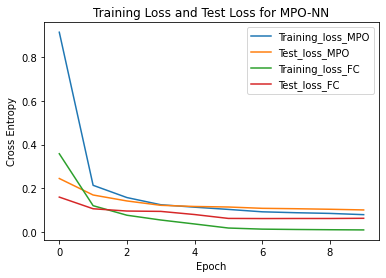

Number of Parameters (MPO):  9400
Accuracy (MPO):  96.83
Forward pass time (MPO):  2.3550949096679688
Number of Parameters (FC):  886875
Accuracy (FC):  98.17
Forward pass time (FC):  2.1748743057250977
Compression Rate: 0.010599013389711065


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline  
plt.plot(train_loss_tt, label = 'Training_loss_MPO')
plt.plot(test_loss_tt, label = 'Test_loss_MPO')
plt.plot(train_loss_fc, label = 'Training_loss_FC')
plt.plot(test_loss_fc, label = 'Test_loss_FC')
plt.title('Training Loss and Test Loss for MPO-NN')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.show()
MPO_size = int(model_MPO.get_number_parameters())
print('Number of Parameters (MPO): ', MPO_size)
print('Accuracy (MPO): ', MPO_acc)
print('Forward pass time (MPO): ', time_MPO)

print('Number of Parameters (FC): ', model_fc.get_number_parameters())
print('Accuracy (FC): ', fc_acc)
print('Forward pass time (FC): ', time_fc)

print('Compression Rate:', MPO_size/model_fc.get_number_parameters())


# [Bonus] Decompose a fullly connected NN
Now that we have showed that by using MPO format to train the neural networks, it can compress a significant amount of parameters. However, another more straight-forward idea would be to use various tensor decomposition methods to decompose and reconstruct the fully-connected layer. In the following practice we will be exploring if this method is duable and if it is better than MPO-NN. 
## Functions for decomposing FCNN via CP, Tucker and TT

#### Data prepration

In [ ]:
def get_newshape(weights, tensor_dim):
  total_elements = weights.shape[0]*weights.shape[1]
  remaining_elements = total_elements
  newshape = []
  while (remaining_elements/tensor_dim).is_integer():
    newshape.append(tensor_dim)
    if remaining_elements/tensor_dim - int(remaining_elements/tensor_dim) == 0:
      remaining_elements /= tensor_dim
    else:
      print('Error getting newshape, cannot reshape the matrix into a tensor')
      break
  if remaining_elements != 1:
    newshape.append(int(remaining_elements))
  return newshape

layers = [model_fc.fc1.weight.data.cpu().numpy(), model_fc.fc2.weight.data.cpu().numpy(), model_fc.fc3.weight.data.cpu().numpy()]

layers_ori_shape = [layer.shape for layer in layers]

tensor_dim = 5
layers_tensor_shape = [get_newshape(layer, tensor_dim) for layer in layers]

layers_tensor = [tl.tensor(layer.reshape(layers_tensor_shape[i])) for i, layer in enumerate(layers)]

(d) Complete the following functions, where the input is the fulled connected layer's weights for FC-NN in its tensor format and the output should be the reconstructed tensor of corresponding tensor decomposition methods and the number of parameters of that decomposition. Note all the `weights` argument is already reshaped into particular tensor shapes and you can directly use tensorly's decomposition functions (e.g. `tensorly.decomposition.parafac` for CP decomposition and  `tensorly.kruskal_to_tensor` to recover the tensor). 

In [ ]:
from tensorly.decomposition import parafac
from tensorly.decomposition import tucker

def get_cp_reconstruction(weights, cp_rank, tol = None):
  weights, factors = parafac(weights, rank=cp_rank, init='random', tol=None)
  num_params = tl.to_numpy(weights).size + np.sum([tl.to_numpy(f).size for f in factors]) 
  # Reconstruct the image from the factors
  cp_reconstruction = tl.kruskal_to_tensor((weights, factors))
  return cp_reconstruction, num_params
  
def get_tt_reconstruction(weights, rank = 10):
  from tensorly.decomposition import matrix_product_state
  factors = matrix_product_state(weights, rank)
  num_params = np.sum([tl.to_numpy(f).size for f in factors])
  from tensorly import mps_to_tensor
  return mps_to_tensor(factors), num_params

def get_tucker_reconstruction(weights, tucker_ranks, tol = None):
  from tensorly.decomposition import tucker
  core, factors = tucker(weights, tucker_ranks)
  num_params = tl.to_numpy(core).size + np.sum([tl.to_numpy(f).size for f in factors])
  return tl.tucker_to_tensor((core, factors)), num_params


## TT

In [ ]:
#TT
tt_ranks = [10, 20, 30, 40, 50]
tt_acc = []
num_parameters_TT = []
for rank_lim in tt_ranks:
  recon_layers = []
  num_param_total = 0
  for layer in layers_tensor:
    recon_layer, num_param_layer = get_tt_reconstruction(layer, rank_lim)
    recon_layers.append(recon_layer)
    num_param_total += num_param_layer
  num_parameters_TT.append(num_param_total)
  recon_model = Net(hidden_units, [layer.reshape(layers_ori_shape[i]) for i, layer in enumerate(recon_layers)])
  recon_model.cuda()
  print('Current TT rank is :' +str(rank_lim))
  tt_acc.append(test(recon_model, device, test_loader, return_acc = True))




Current TT rank is :10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()



Test set: Average loss: 2.2117, Accuracy: 1905/10000 (19%)

Current TT rank is :20

Test set: Average loss: 1.2556, Accuracy: 6061/10000 (61%)

Current TT rank is :30

Test set: Average loss: 0.4111, Accuracy: 8700/10000 (87%)

Current TT rank is :40

Test set: Average loss: 0.1553, Accuracy: 9517/10000 (95%)

Current TT rank is :50

Test set: Average loss: 0.1038, Accuracy: 9676/10000 (97%)



## Tucker

In [ ]:
import gc
gc.collect()
#Tucker
Tucker_rank_list = [2, 3, 4]
tucker_acc = []
num_parameters_tucker = []
for tucker_rank in Tucker_rank_list:
  print('Current Tucker rank is :' +str(tucker_rank))
  recon_layers = []
  num_param_total = 0
  for layer in layers_tensor:
    tucker_ranks = np.ones(tl.ndim(layer)).astype(int)*tucker_rank
    recon_layer, num_param_layer = get_tucker_reconstruction(layer, tucker_ranks)
    recon_layers.append(recon_layer)
    num_param_total += num_param_layer
  num_parameters_tucker.append(num_param_total)
  recon_model = Net(hidden_units, [layer.reshape(layers_ori_shape[i]) for i, layer in enumerate(recon_layers)])
  recon_model.cuda()
  tucker_acc.append(test(recon_model, device, test_loader, return_acc = True))

Current Tucker rank is :2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()



Test set: Average loss: 2.3027, Accuracy: 958/10000 (10%)

Current Tucker rank is :3

Test set: Average loss: 2.2985, Accuracy: 786/10000 (8%)

Current Tucker rank is :4

Test set: Average loss: 2.1868, Accuracy: 1520/10000 (15%)



## CP

In [ ]:
import gc
gc.collect()
#set up CP pararmeters
cp_ranks = [10, 50, 100, 200, 300, 400, 500]
cp_acc = []
num_parameters_cp = []

for cp_rank in cp_ranks:
  recon_layers = []
  num_param_total = 0
  print('Current CP rank is :' +str(cp_rank))
  for layer in layers_tensor:
    recon_layer, num_param_layer = get_cp_reconstruction(layer, cp_rank)
    recon_layers.append(recon_layer)
    num_param_total += num_param_layer
  num_parameters_cp.append(num_param_total)
  recon_model = Net(hidden_units, [layer.reshape(layers_ori_shape[i]) for i, layer in enumerate(recon_layers)])
  recon_model.cuda()
  cp_acc.append(test(recon_model, device, test_loader, return_acc = True))

Current CP rank is :10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  app.launch_new_instance()



Test set: Average loss: 2.2926, Accuracy: 933/10000 (9%)

Current CP rank is :50

Test set: Average loss: 2.4194, Accuracy: 1033/10000 (10%)

Current CP rank is :100

Test set: Average loss: 2.5244, Accuracy: 1447/10000 (14%)

Current CP rank is :200

Test set: Average loss: 2.2979, Accuracy: 2860/10000 (29%)

Current CP rank is :300

Test set: Average loss: 1.7522, Accuracy: 4431/10000 (44%)

Current CP rank is :400

Test set: Average loss: 1.3265, Accuracy: 4947/10000 (49%)

Current CP rank is :500

Test set: Average loss: 0.9604, Accuracy: 6002/10000 (60%)



## Results

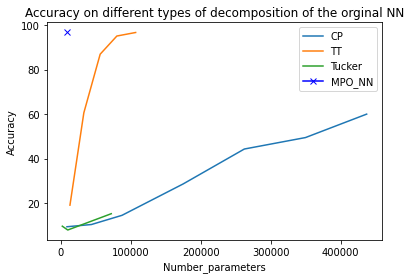

In [ ]:
plt.plot( num_parameters_cp, cp_acc, label = 'CP')
plt.plot( num_parameters_TT, tt_acc, label = 'TT')
plt.plot( num_parameters_tucker, tucker_acc, label = 'Tucker')
plt.plot( MPO_size, MPO_acc, '-bx', label = 'MPO_NN')
plt.legend()
plt.xlabel('Number_parameters')
plt.ylabel('Accuracy')
plt.title('Accuracy on different types of decomposition of the orginal NN')
plt.show()
